<a href="https://colab.research.google.com/github/fardsnog2/Innopolis_first_block/blob/main/3_6_%D0%94%D0%BE%D0%BC%D0%B0%D1%88%D0%BD%D0%B5%D0%B5_%D0%B7%D0%B0%D0%B4%D0%B0%D0%BD%D0%B8%D0%B5_%D0%BF%D0%BE_%D0%BA%D0%BB%D0%B0%D1%81%D1%81%D0%B8%D1%84%D0%B8%D0%BA%D0%B0%D1%86%D0%B8%D0%B8_%D1%82%D0%B5%D0%BA%D1%81%D1%82%D0%BE%D0%B2_%D1%81_%D0%B8%D1%81%D0%BF_%D0%98%D0%9D%D0%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Классификация текстов
# Домашнее задание — мультиклассовая классификация по вопросам о языках программирования на Stack Overflow

В новой задаче используется датасет с несколькими тысячами вопросов по четырём языкам программирования со Stack Overflow. Он извлечён из датасета [BigQuery](https://console.cloud.google.com/marketplace/details/stack-exchange/stack-overflow) с более чем 17 миллионами вопросов.

Все упоминания целевых языков программирования в данных заменены на *blank*.

Необходимо внести в учебный блокнот по классификации данных с IMDB следующие изменения:

- Скачать новый подготовленный набор данных (датасет): [Stack Overflow dataset](https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz) (адрес: https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz).

Структура файлов  в архиве с данными:

```
train/
...python/
......0.txt
......1.txt
...javascript/
......0.txt
......1.txt
...csharp/
......0.txt
......1.txt
...java/
......0.txt
......1.txt
```

Изменить части кода, отвечающие новой задаче классификации, которая теперь мультиклассовая:

- Заменить размерность последнего полносвязного слоя для нового количества предсказываемых классов.

- Использовать функцию потерь, подходящую для целочисленных меток классов: `tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)`. Метрика должна иметь значение `metrics=['accuracy']` (`tf.metrics.BinaryAccuracy` только для бинарной классификации.

- При построении графиков скорректируйте метрики на те, которые реально используются вами в решении.


# Для основы возьмите бинарный случай классификации, который был разобран на уроке.

In [32]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses

In [33]:
url = "https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz"

dataset = tf.keras.utils.get_file("stack_overflow_16k", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'stack_overflow_16k')
dataset

'./stack_overflow_16k'

In [34]:
train_dir = 'train'
os.listdir(train_dir)

['python', 'java', 'csharp', 'javascript']

In [35]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

Found 8000 files belonging to 4 classes.
Using 6400 files for training.


In [36]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

Found 8000 files belonging to 4 classes.
Using 1600 files for validation.


In [37]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'test',
    batch_size=batch_size)

Found 8000 files belonging to 4 classes.


In [38]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

In [39]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [40]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [41]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [42]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'"unit testing of setters and getters teacher wanted us to do a comprehensive unit test. for me, this will be the first time that i use junit. i am confused about testing set and get methods. do you think should i test them? if the answer is yes; is this code enough for testing?..  public void testsetandget(){.    int a = 10;.    class firstclass = new class();.    firstclass.setvalue(10);.    int value = firstclass.getvalue();.    assert.asserttrue(""error"", value==a);.  }...in my code, i think if there is an error, we can\'t know that the error is deriving because of setter or getter."\n', shape=(), dtype=string)
Label java
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[1011,  773,    9, 2456,    8, 1863, 2362,  690, 1267,    4,   40,
           5,    1, 1011,  196,   12,   74,   13,   72,   33,    2,   98,
         105,   14,    3,   70, 9611,    3,   34,  888,  202,  773,  107,
           8,   41,  242,   40,   58,  291,   90,    3,  1

In [43]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [44]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [46]:
embedding_dim = 16

In [62]:
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(4)])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 16)          160016    
                                                                 
 dropout_6 (Dropout)         (None, None, 16)          0         
                                                                 
 global_average_pooling1d_3  (None, 16)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_7 (Dropout)         (None, 16)                0         
                                                                 
 dense_3 (Dense)             (None, 4)                 68        
                                                                 
Total params: 160084 (625.33 KB)
Trainable params: 160084 (625.33 KB)
Non-trainable params: 0 (0.00 Byte)
______________

In [63]:
model.compile(loss=losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=['accuracy'])

In [64]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
200/200 [==============================] - 21s 102ms/step - loss: 1.3791 - accuracy: 0.3378 - val_loss: 1.3677 - val_accuracy: 0.4712
Epoch 2/10
200/200 [==============================] - 1s 4ms/step - loss: 1.3495 - accuracy: 0.4603 - val_loss: 1.3273 - val_accuracy: 0.5113
Epoch 3/10
200/200 [==============================] - 1s 4ms/step - loss: 1.2973 - accuracy: 0.5306 - val_loss: 1.2658 - val_accuracy: 0.5694
Epoch 4/10
200/200 [==============================] - 1s 4ms/step - loss: 1.2270 - accuracy: 0.6000 - val_loss: 1.1909 - val_accuracy: 0.6313
Epoch 5/10
200/200 [==============================] - 1s 4ms/step - loss: 1.1472 - accuracy: 0.6586 - val_loss: 1.1134 - val_accuracy: 0.6700
Epoch 6/10
200/200 [==============================] - 1s 4ms/step - loss: 1.0704 - accuracy: 0.6869 - val_loss: 1.0409 - val_accuracy: 0.7031
Epoch 7/10
200/200 [==============================] - 1s 4ms/step - loss: 0.9989 - accuracy: 0.7181 - val_loss: 0.9767 - val_accuracy: 0.7219
Epo

In [65]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

250/250 [==============================] - 1s 2ms/step - loss: 0.8631 - accuracy: 0.7301
Loss:  0.863082230091095
Accuracy:  0.7301250100135803


In [66]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

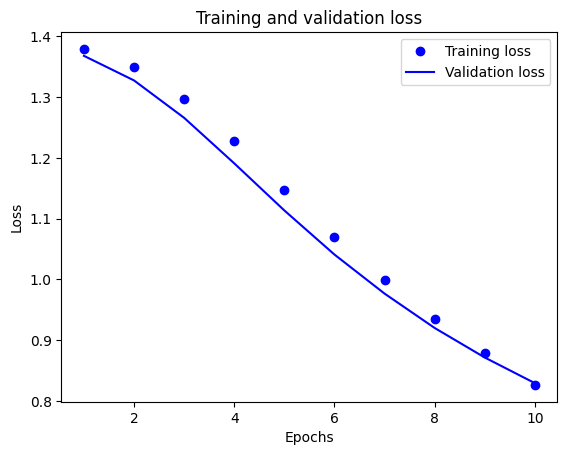

In [67]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

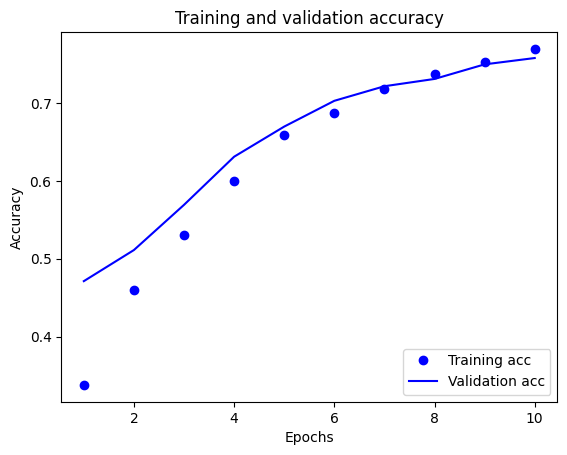

In [68]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()